In [18]:
import torch
import xarray as xr
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, TensorDataset
import dask
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim

In [6]:
ds = xr.open_zarr("dataset/chile_2010_january.zarr")
print(ds)

<xarray.Dataset> Size: 47MB
Dimensions:              (time: 124, latitude: 157, longitude: 121)
Coordinates:
  * latitude             (latitude) float32 628B -17.0 -17.25 ... -55.75 -56.0
    level                int64 8B ...
  * longitude            (longitude) float32 484B 280.0 280.2 ... 309.8 310.0
  * time                 (time) datetime64[ns] 992B 2010-01-01 ... 2010-01-31...
Data variables:
    geopotential         (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>
    specific_humidity    (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>
    temperature          (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>
    u_component_of_wind  (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>
    v_component_of_wind  (time, latitude, longitude) float32 9MB dask.array<chunksize=(10, 50, 50), meta=np.ndarray>


In [9]:
def preprocess_dataset(ds, variables, train_time_scale, val_time_scale, test_time_scale):
    train_vars = [ds[var].sel(time=train_time_scale).values for var in variables]  # Entrenamiento
    val_vars = [ds[var].sel(time=val_time_scale).values for var in variables]     # Validación
    test_vars = [ds[var].sel(time=test_time_scale).values for var in variables]   # Prueba

    train_data = np.array(train_vars)
    val_data = np.array(val_vars)
    test_data = np.array(test_vars)

    train_data = torch.tensor(train_data, dtype=torch.float32)
    val_data = torch.tensor(val_data, dtype=torch.float32)
    test_data = torch.tensor(test_data, dtype=torch.float32)

    lat, lon = train_data.shape[2], train_data.shape[3]

    means = train_data.mean(dim=(1, 2, 3), keepdim=True)
    stds = train_data.std(dim=(1, 2, 3), keepdim=True)
    
    train_data = (train_data - means) / stds
    val_data = (val_data - means) / stds
    test_data = (test_data - means) / stds

    return train_data, val_data, test_data, lat, lon, means, stds

In [4]:
train_time_scale = slice("2010-01-01", "2010-01-20")
val_time_scale = slice("2010-01-21", "2010-01-25")
test_time_scale = slice("2010-01-26", "2010-01-31")

In [7]:
variables = ['geopotential', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind']

In [13]:
train_data, val_data, test_data, lat, lon, means, stds = preprocess_dataset(
    ds, 
    variables, 
    train_time_scale, 
    val_time_scale, 
    test_time_scale
)

train_data = train_data.permute(1, 0, 2, 3)
val_data = val_data.permute(1, 0, 2, 3)
test_data = test_data.permute(1, 0, 2, 3)

print("Train Data Shape:", train_data.shape)
print("Validation Data Shape:", val_data.shape)
print("Test Data Shape:", test_data.shape)

Train Data Shape: torch.Size([80, 5, 157, 121])
Validation Data Shape: torch.Size([20, 5, 157, 121])
Test Data Shape: torch.Size([24, 5, 157, 121])


In [14]:
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)
test_dataset = TensorDataset(test_data)

batch_size = 8  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for batch in train_loader:
    print("Train Batch Shape:", batch[0].shape)
    break

Train Batch Shape: torch.Size([8, 5, 157, 121])


In [ ]:
class SimpleClimateModel(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(SimpleClimateModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, output_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


In [20]:
def train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=5):
    model.to(device)
    for epoch in range(epochs):
        # Entrenamiento
        model.train()
        train_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_data = batch[0].to(device)
            output = model(input_data)
            loss = loss_fn(output, input_data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validación
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_data = batch[0].to(device)
                output = model(input_data)
                loss = loss_fn(output, input_data)
                val_loss += loss.item()
        
        # Imprimir pérdidas
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}")


In [21]:
epochs = 5
model = SimpleClimateModel(input_channels, output_channels)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_model(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=epochs)

Epoch 1/5, Training Loss: 0.8327, Validation Loss: 0.5052
Epoch 2/5, Training Loss: 0.3452, Validation Loss: 0.2573
Epoch 3/5, Training Loss: 0.2020, Validation Loss: 0.1568
Epoch 4/5, Training Loss: 0.1196, Validation Loss: 0.0882
Epoch 5/5, Training Loss: 0.0801, Validation Loss: 0.0674


In [22]:
def evaluate_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            input_data = batch[0].to(device)
            output = model(input_data)
            loss = loss_fn(output, input_data)
            total_loss += loss.item()
    return total_loss / len(data_loader)


In [23]:
test_loss = evaluate_model(model, test_loader, loss_fn, device)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.0814


In [24]:
def mean_absolute_error(model, data_loader, device):
    model.eval()
    total_mae = 0
    with torch.no_grad():
        for batch in data_loader:
            input_data = batch[0].to(device)
            output = model(input_data)
            mae = torch.abs(output - input_data).mean().item()
            total_mae += mae
    return total_mae / len(data_loader)

test_mae = mean_absolute_error(model, test_loader, device)
print(f"Mean Absolute Error (MAE): {test_mae:.4f}")


Mean Absolute Error (MAE): 0.2078


In [29]:
def generate_spatial_embeddings(latitudes, longitudes):
    """
    Genera embeddings trigonométricos para latitud y longitud.
    """
    lat_rad = torch.tensor(np.radians(latitudes), dtype=torch.float32)  # Convertir a radianes
    lon_rad = torch.tensor(np.radians(longitudes), dtype=torch.float32)

    # Expandir dimensiones para generar una cuadrícula completa
    sin_lat = torch.sin(lat_rad).unsqueeze(1).expand(-1, len(longitudes))  # Shape: (lat, lon)
    cos_lat = torch.cos(lat_rad).unsqueeze(1).expand(-1, len(longitudes))
    sin_lon = torch.sin(lon_rad).unsqueeze(0).expand(len(latitudes), -1)  # Shape: (lat, lon)
    cos_lon = torch.cos(lon_rad).unsqueeze(0).expand(len(latitudes), -1)

    # Combinar embeddings en una cuadrícula de 4 canales
    spatial_embeddings = torch.stack([
        sin_lat * cos_lon, sin_lat * sin_lon,
        cos_lat * cos_lon, cos_lat * sin_lon
    ], dim=0)  # Shape: (4, lat, lon)

    return spatial_embeddings


In [26]:
def generate_temporal_embeddings(time_steps):
    """
    Genera embeddings temporales usando funciones trigonométricas.
    """
    day_of_year = (time_steps.dayofyear / 365.0) * 2 * np.pi
    hour_of_day = (time_steps.hour / 24.0) * 2 * np.pi

    # Embeddings seno y coseno
    sin_day = torch.sin(torch.tensor(day_of_year, dtype=torch.float32)).unsqueeze(1)
    cos_day = torch.cos(torch.tensor(day_of_year, dtype=torch.float32)).unsqueeze(1)
    sin_hour = torch.sin(torch.tensor(hour_of_day, dtype=torch.float32)).unsqueeze(1)
    cos_hour = torch.cos(torch.tensor(hour_of_day, dtype=torch.float32)).unsqueeze(1)

    # Combinar embeddings
    temporal_embeddings = torch.cat([sin_day, cos_day, sin_hour, cos_hour], dim=1)  # Shape: (time, 4)
    return temporal_embeddings

In [30]:
latitudes = ds.latitude.values
longitudes = ds.longitude.values
spatial_embeddings = generate_spatial_embeddings(latitudes, longitudes)
print("Spatial Embeddings Shape:", spatial_embeddings.shape)  # Esperado: (4, lat, lon)

Spatial Embeddings Shape: torch.Size([4, 157, 121])


In [28]:
time_steps = ds.time.to_index()  # Convertir a datetime
temporal_embeddings = generate_temporal_embeddings(time_steps)
print("Temporal Embeddings Shape:", temporal_embeddings.shape) 

Temporal Embeddings Shape: torch.Size([124, 4])


In [38]:
# Índices del tiempo de entrenamiento
train_time_indices = range(len(train_data))  # 80 pasos de tiempo

# Ajustar embeddings espaciales para el tiempo de entrenamiento
spatial_embeddings_expanded = spatial_embeddings.unsqueeze(0).expand(len(train_time_indices), -1, -1, -1)  # Shape: (80, 4, 157, 121)

# Ajustar embeddings temporales para el tiempo de entrenamiento
temporal_embeddings_expanded = temporal_embeddings[train_time_indices].unsqueeze(-1).unsqueeze(-1)  # (80, 4, 1, 1)
temporal_embeddings_expanded = temporal_embeddings_expanded.expand(-1, -1, len(ds.latitude), len(ds.longitude))  # Shape: (80, 4, 157, 121)

# Combinar datos climáticos con embeddings espaciales y temporales
combined_data = torch.cat([train_data, spatial_embeddings_expanded, temporal_embeddings_expanded], dim=1)
print("Combined Data Shape:", combined_data.shape)  # Esperado: (80, 13, 157, 121)


Combined Data Shape: torch.Size([80, 13, 157, 121])


In [39]:
class ClimateModelWithEmbeddings(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(ClimateModelWithEmbeddings, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, output_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [48]:
combined_dataset = TensorDataset(combined_data)
combined_train_loader = DataLoader(combined_dataset, batch_size=8, shuffle=True)

In [63]:
spatial_embeddings_val = spatial_embeddings.unsqueeze(0).expand(len(val_data), -1, -1, -1) 

temporal_embeddings_val = temporal_embeddings[:len(val_data)].unsqueeze(-1).unsqueeze(-1)  
temporal_embeddings_val = temporal_embeddings_val.expand(-1, -1, len(ds.latitude), len(ds.longitude))  

combined_val_data = torch.cat([val_data, spatial_embeddings_val, temporal_embeddings_val], dim=1) 

combined_val_dataset = TensorDataset(combined_val_data)
combined_val_loader = DataLoader(combined_val_dataset, batch_size=8, shuffle=False)


In [64]:
combined_val_data.shape

torch.Size([20, 13, 157, 121])

In [67]:
# Ajustar embeddings temporales para el conjunto de prueba
temporal_embeddings_test = temporal_embeddings[:len(test_data)].unsqueeze(-1).unsqueeze(-1)  # (24, 4, 1, 1)
temporal_embeddings_test = temporal_embeddings_test.expand(-1, -1, len(ds.latitude), len(ds.longitude))  # (24, 4, 157, 121)

# Combinar datos climáticos con embeddings espaciales y temporales para prueba
spatial_embeddings_test = spatial_embeddings.unsqueeze(0).expand(len(test_data), -1, -1, -1)  # (24, 4, 157, 121)
combined_test_data = torch.cat([test_data, spatial_embeddings_test, temporal_embeddings_test], dim=1)  # (24, 13, 157, 121)

# Crear DataLoader para prueba
combined_test_dataset = TensorDataset(combined_test_data)
combined_test_loader = DataLoader(combined_test_dataset, batch_size=8, shuffle=False)


In [68]:
combined_test_data.shape

torch.Size([24, 13, 157, 121])

In [65]:
input_channels = 13  # 5 variables climáticas + 4 embeddings espaciales + 4 embeddings temporales
output_channels = 13  # Reconstruir todos los canales
model = ClimateModelWithEmbeddings(input_channels, output_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()  # Pérdida basada en el error cuadrático medio
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 5  # Número de épocas
for epoch in range(epochs):
    # Modo entrenamiento
    model.train()
    train_loss = 0
    for batch in combined_train_loader:
        optimizer.zero_grad()
        input_data = batch[0].to(device)  # Usar datos combinados
        output = model(input_data)  # Pasada hacia adelante
        loss = loss_fn(output, input_data)  # Pérdida basada en la reconstrucción
        loss.backward()  # Gradiente hacia atrás
        optimizer.step()  # Actualizar los parámetros del modelo
        train_loss += loss.item()
    
    # Pérdida de entrenamiento para esta época
    avg_train_loss = train_loss / len(combined_train_loader)

    # Validación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in combined_val_loader:  # Usar el nuevo val_loader combinado
            input_data = batch[0].to(device)  # Datos combinados
            output = model(input_data)
            loss = loss_fn(output, input_data)
            val_loss += loss.item()
    
    # Pérdida promedio de validación
    avg_val_loss = val_loss / len(combined_val_loader)
    
    # Imprimir pérdidas de la época
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")



Epoch 1/5, Training Loss: 0.3744, Validation Loss: 0.1928
Epoch 2/5, Training Loss: 0.1375, Validation Loss: 0.0998
Epoch 3/5, Training Loss: 0.0728, Validation Loss: 0.0527
Epoch 4/5, Training Loss: 0.0378, Validation Loss: 0.0341
Epoch 5/5, Training Loss: 0.0269, Validation Loss: 0.0264


In [69]:
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in combined_test_loader:  # Usar el DataLoader combinado del conjunto de prueba
        input_data = batch[0].to(device)  # Datos combinados
        output = model(input_data)
        loss = loss_fn(output, input_data)  # Pérdida basada en la reconstrucción
        test_loss += loss.item()

avg_test_loss = test_loss / len(combined_test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 0.0254


In [70]:
# Función para calcular el gradiente de un tensor en dirección espacial
def compute_gradient(x, dim):
    return torch.gradient(x, dim=dim)[0]

# Función que incorpora las restricciones físicas de advección
def physics_loss(temperature, u, v, dx, dy):
    # Gradientes de la temperatura en las direcciones espaciales
    grad_T_x = compute_gradient(temperature, 3)  # Gradiente en la dirección x (lon)
    grad_T_y = compute_gradient(temperature, 2)  # Gradiente en la dirección y (lat)
    
    # Cálculo de la advección (producto de la velocidad y gradiente)
    advection_x = u * grad_T_x
    advection_y = v * grad_T_y
    
    # Cálculo de la ecuación de advección
    loss = torch.mean((advection_x + advection_y)**2)  # La pérdida debe ser pequeña
    return loss

# Modificar la función de pérdida para incluir la física
def combined_loss(output, input_data, u, v, dx, dy):
    data_loss = nn.MSELoss()(output, input_data)  # Pérdida basada en la reconstrucción
    pde_loss = physics_loss(output, u, v, dx, dy)  # Pérdida basada en la física
    return data_loss + pde_loss  # Combinamos ambas pérdidas


In [77]:
def get_wind_components(input_data):
    u = input_data[:, 3, :, :].unsqueeze(1)  # Agregar dimensión de canal
    v = input_data[:, 4, :, :].unsqueeze(1)  # Agregar dimensión de canal
    return u, v

In [86]:
input_channels = 13  # 5 variables climáticas + 4 embeddings espaciales + 4 embeddings temporales
output_channels = 13  # Reconstruir todos los canales
model = ClimateModelWithEmbeddings(input_channels, output_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()  # Pérdida basada en el error cuadrático medio
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Entrenamiento con PINNs
epochs = 100  # Número de épocas
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in combined_train_loader:
        optimizer.zero_grad()
        input_data = batch[0].to(device)  # Usar datos combinados
        output = model(input_data)  # Pasada hacia adelante
        
        # Asumiendo que tenemos los valores de viento (u, v)
        u, v = get_wind_components(input_data)  # Función para obtener u y v (debe ser definida)
        dx, dy = 1, 1  # Si es necesario, ajusta estos valores según la resolución espacial

        # Usar la función de pérdida combinada
        loss = combined_loss(output, input_data, u, v, dx, dy)
        loss.backward()  # Gradiente hacia atrás
        optimizer.step()  # Actualizar los parámetros del modelo
        train_loss += loss.item()
    
    # Pérdida promedio de entrenamiento para la época actual
    avg_train_loss = train_loss / len(combined_train_loader)
    
    # Evaluación
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in combined_val_loader:  # Usar el DataLoader combinado de validación
            input_data = batch[0].to(device)
            output = model(input_data)
            
            u, v = get_wind_components(input_data)  # Obtener u, v
            loss = combined_loss(output, input_data, u, v, dx, dy)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(combined_val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


Epoch 1/100, Training Loss: 0.3677, Validation Loss: 0.1835
Epoch 2/100, Training Loss: 0.1464, Validation Loss: 0.0971
Epoch 3/100, Training Loss: 0.0711, Validation Loss: 0.0592
Epoch 4/100, Training Loss: 0.0457, Validation Loss: 0.0441
Epoch 5/100, Training Loss: 0.0336, Validation Loss: 0.0358
Epoch 6/100, Training Loss: 0.0253, Validation Loss: 0.0286
Epoch 7/100, Training Loss: 0.0216, Validation Loss: 0.0281
Epoch 8/100, Training Loss: 0.0195, Validation Loss: 0.0268
Epoch 9/100, Training Loss: 0.0182, Validation Loss: 0.0241
Epoch 10/100, Training Loss: 0.0169, Validation Loss: 0.0222
Epoch 11/100, Training Loss: 0.0160, Validation Loss: 0.0211
Epoch 12/100, Training Loss: 0.0152, Validation Loss: 0.0206
Epoch 13/100, Training Loss: 0.0147, Validation Loss: 0.0187
Epoch 14/100, Training Loss: 0.0142, Validation Loss: 0.0187
Epoch 15/100, Training Loss: 0.0137, Validation Loss: 0.0189
Epoch 16/100, Training Loss: 0.0133, Validation Loss: 0.0171
Epoch 17/100, Training Loss: 0.01

In [87]:
# Evaluación en el conjunto de prueba
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in combined_test_loader:
        input_data = batch[0].to(device)  # Datos combinados del conjunto de prueba
        output = model(input_data)  # Predicción del modelo
        
        u, v = get_wind_components(input_data)  # Obtener componentes del viento
        dx, dy = 1, 1  # Ajustar si es necesario según la resolución espacial
        
        # Pérdida combinada (reconstrucción + física)
        loss = combined_loss(output, input_data, u, v, dx, dy)
        test_loss += loss.item()

# Pérdida promedio del conjunto de prueba
avg_test_loss = test_loss / len(combined_test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 0.0070


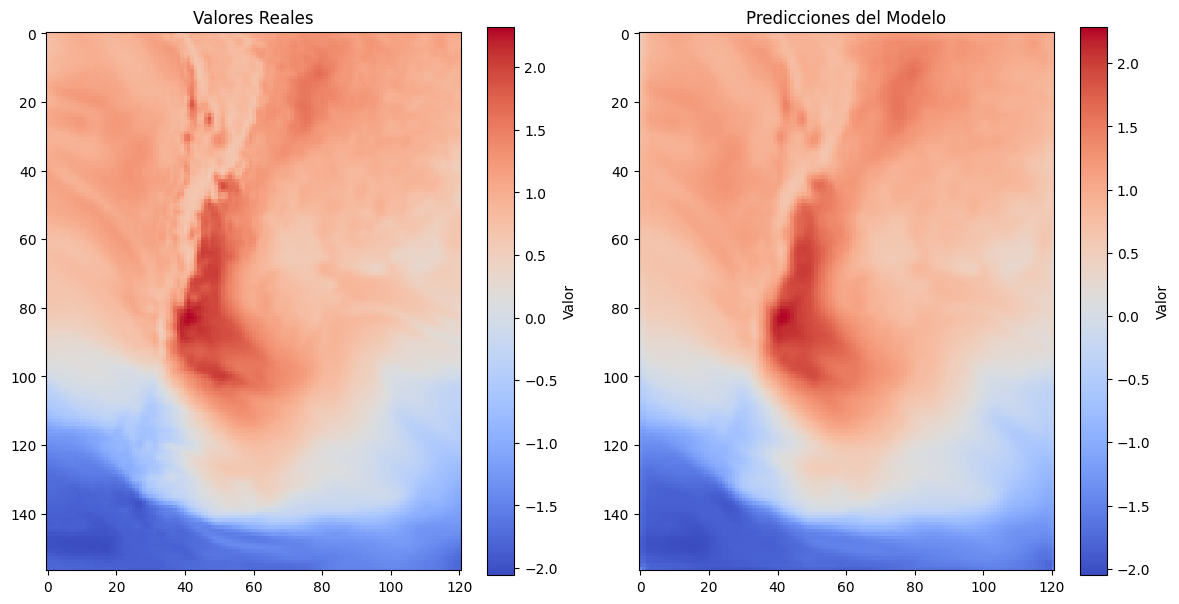

In [88]:
# Elegir un batch del conjunto de prueba
batch = next(iter(combined_test_loader))
input_data = batch[0].to(device)  # Datos reales combinados
output = model(input_data).detach().cpu()  # Predicción del modelo (sin gradientes)

# Seleccionar una variable (ejemplo: temperatura en el canal 2)
variable_index = 2  # Índice de la variable climática a visualizar
real_data = input_data[:, variable_index, :, :].cpu().numpy()  # Datos reales
predicted_data = output[:, variable_index, :, :].numpy()  # Predicciones del modelo

# Elegir un paso de tiempo específico
time_step = 0  # Puedes cambiar el índice del batch aquí

# Visualizar los datos reales y predicciones
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Valores Reales")
plt.imshow(real_data[time_step], cmap="coolwarm")
plt.colorbar(label="Valor")

plt.subplot(1, 2, 2)
plt.title("Predicciones del Modelo")
plt.imshow(predicted_data[time_step], cmap="coolwarm")
plt.colorbar(label="Valor")

plt.tight_layout()
plt.show()